# Demand prediction at one store 



In [1]:
selected_store='791b56e7-ac51-432f-b75d-17d6556a42ae' # select a store 


In [2]:
import os
directory=os.getcwd()
#print(directory)


In [85]:
#import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 
import datetime as dt
import fbprophet
print(fbprophet.__version__)


0.7.1


In [86]:
import warnings
warnings.filterwarnings("ignore")

In [87]:
# Import customer list
u_df=pd.read_csv('./Users_sanitized.csv', sep=',', index_col='UserId').drop('Unnamed: 0',axis=1)
u_df.head()

CreationTimestamp  \
UserId                                                                
c80419f9-49c8-40fc-9235-a00e11535441  2020-10-28 11:16:26.078405+00   
79f8cb9f-845a-435d-a90f-2c4e1c6b184d  2020-07-02 11:02:15.328493+00   
885f9e83-82a7-4b27-9c77-c0efa2d37717  2020-09-14 13:17:28.633744+00   
4c9e5562-40d5-4b2d-bdcb-997fae59fcb5  2021-04-02 13:47:46.115381+00   
8fc09966-88e1-45d5-a1ac-b923e37ea3a1  2020-01-04 22:09:01.160486+00   

                                         ClaimType  IsOfflineUser  
UserId                                                             
c80419f9-49c8-40fc-9235-a00e11535441  storeappuser          False  
79f8cb9f-845a-435d-a90f-2c4e1c6b184d      consumer          False  
885f9e83-82a7-4b27-9c77-c0efa2d37717      consumer          False  
4c9e5562-40d5-4b2d-bdcb-997fae59fcb5      consumer          False  
8fc09966-88e1-45d5-a1ac-b923e37ea3a1      consumer          False

In [88]:


#df = pd.read_csv('./data/211022_Opening Hours.csv', parse_dates='StartTime', date_parser=date_utc)

oh_df=pd.read_csv('./data/211022_Opening Hours.csv', sep=',', index_col='Id').set_index('StoreId')
oh_df['StartTime']= pd.to_datetime(oh_df['StartTime']).dt.tz_localize('Europe/Berlin')
oh_df['EndTime']= pd.to_datetime(oh_df['EndTime']).dt.tz_localize('Europe/Berlin')

#oh_df.loc[selected_store,]

In [89]:
%store -r co_store_delta
m_df=co_store_delta.copy()

m_df.loc[selected_store,]

MerchantId                  081baec5-ae6d-4cea-90da-1e3982076e92
Name                 Polizeipräsidium Köln - Betriebsgastronomie
Longitude                                               6.994708
Latitude                                               50.938218
CreationDate                    2020-09-16 20:46:39.999356+02:00
CategoryId                                                     4
StreetAddress                                Walter-Pauli-Ring 2
City                                                        Köln
SellsOfflineCards                                           True
geometry                POINT (6.9947075843811 50.9382176399231)
check_ins                                                 9109.0
check_outs                                               -9273.0
delta                                                     -164.0
cater_in                                                     0.0
cater_out                                                    0.0
cater_delta              

In [90]:
# plot stores
import folium

map_osm = folium.Map(location=[51, 6.9],zoom_start=11)

folium.Marker(location=[m_df.loc[selected_store,]["Latitude"], m_df.loc[selected_store,]["Longitude"]],radius=2, popup=selected_store).add_to(map_osm)
map_osm

In [91]:
# Choose the time window for the analysis

begin_date=dt.datetime(2019, 8, 1, 0, 0, 0, tzinfo=dt.timezone.utc)
end_date=dt.datetime(2022, 8, 31, 23, 59, 0, tzinfo=dt.timezone.utc)#.tz_convert(tz='Europe/Berlin')



In [92]:
# drop the redundant columns 

drop_list=['Unnamed: 0', 'OwnerSince_r','Source', 'Target','TransactionId']
try:
    out_df=pd.read_csv('./c_co_out.csv', sep=',', low_memory=False).drop(drop_list, axis=1)
except: print('no list')


%store -r c_co_in
%store -r c_co_out


begin_=c_co_out['OwnerSince']>begin_date
end_=c_co_out['OwnerSince']<end_date


out_df=c_co_out[begin_ & end_]


store_out=out_df[out_df['owner_store_id']==selected_store].copy()

#store_out.head(2)


begin_=c_co_in['OwnerTill']>begin_date
end_=c_co_in['OwnerTill']<end_date



in_df=c_co_in[begin_ & end_]
#in_df.tail()

store_in=in_df[in_df['next_owner_store_id']==selected_store].copy()

no list


## Inventory levels at each period.
 

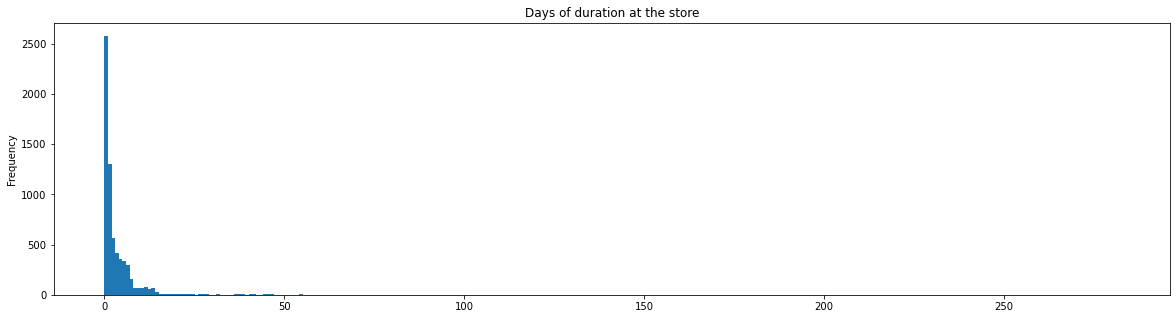

In [93]:
# plt how long containers stay in the restaurant 
# This graph does not convey much information. Some of the containers can be forgotten somewhere in the restaurant.
# They might be at the bottom of the containers pile.
bin_=((store_in['OwnerTill']-store_in['OwnerSince']).dt.total_seconds()/3600/24).max().astype(int)

plt.figure(figsize=(20,5))
plt.title('Days of duration at the store')
plt.ylabel('Frequency')

plt.hist((store_in['OwnerTill']-store_in['OwnerSince']).dt.total_seconds()/3600/24, bins=bin_) # convert to day
plt.show()

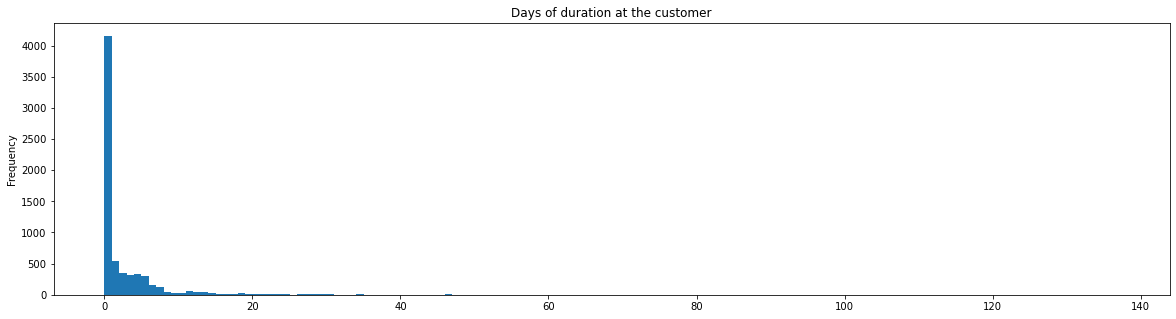

In [94]:

# plt shows how long containers stay with customer 
# This graph reveals very valuable info. 
# Most of customers return the contsiners around in an hour. 
bin_=((store_out['OwnerTill']-store_out['OwnerSince']).dt.total_seconds()/3600/24).max().astype(int)


plt.figure(figsize=(20,5))
plt.title('Days of duration at the customer')
plt.ylabel('Frequency')

plt.hist((store_out['OwnerTill']-store_out['OwnerSince']).dt.total_seconds()/3600/24, bins=bin_) # convert to days 
plt.show()


In [95]:
#store_out.columns

## Time Series

### Hourly

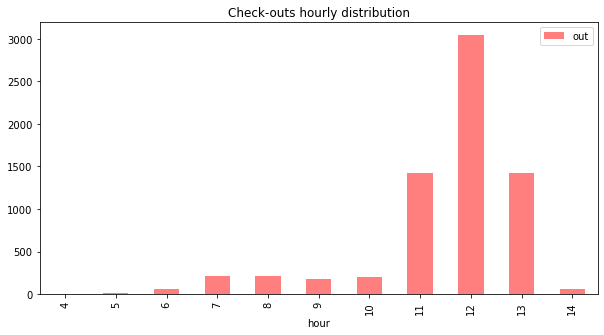

In [96]:
# create a new df after grouping by days.

ops_h=store_out.groupby(store_out['OwnerSince'].dt.hour).size() # going out containers

ops_h=pd.DataFrame(ops_h, columns=['out'])
ops_h.index.names=['hour']

ops_h['in']=store_in.groupby(store_in['OwnerTill'].dt.hour).size()

ops_h=ops_h.fillna(0)
ops_h['sum']=ops_h['out']+ops_h['in']


plt.figure(figsize=(10, 5))
plt.title('Check-outs hourly distribution')

ops_h['out'].plot.bar(color='red', legend=True, alpha=0.5)
plt.show()

### Daily

### count either containers or consumers

In [97]:
# create a new df after grouping by days.

#ops_day=store_out.groupby(store_out['OwnerSince'].dt.date).size().to_frame('out')*(-1) # going out containers
ops_day=store_out.groupby(store_out['OwnerSince'].dt.date)['NextOwnerId'].nunique().to_frame('out')*(-1) # !!!!!!consumers


ops_day.index.names=['Date']

#ops_day['in']=store_in.groupby(store_in['OwnerTill'].dt.date).size()
ops_day['in']=store_in.groupby(store_in['OwnerTill'].dt.date)['OwnerId'].nunique()

ops_day=ops_day.fillna(0)
ops_day['sum']=ops_day['out']+ops_day['in']

# create a bin including empty days between the range of earliest and latest day that a transaction took place
bins=pd.date_range(start=pd.to_datetime(ops_day.index).min(), end=pd.to_datetime(ops_day.index).max())
bins=pd.to_datetime(bins)
bins=pd.Series(bins).dt.date
bins=pd.DataFrame(bins, columns=['date'])


# add this bin as an index into df with merge operation
# now, we have all days in the df
ops_day['date']=pd.to_datetime(ops_day.index)
ops_day['date']=ops_day['date'].dt.date
ops_day.index=ops_day['date']

ops_day=pd.merge(bins,ops_day, how='left', left_on=bins['date'], \
                 right_index=True).fillna(0).drop('date_y', axis=1).rename(columns={'date_x':'date'}).set_index('date')
ops_day['date']=pd.to_datetime(ops_day.index)


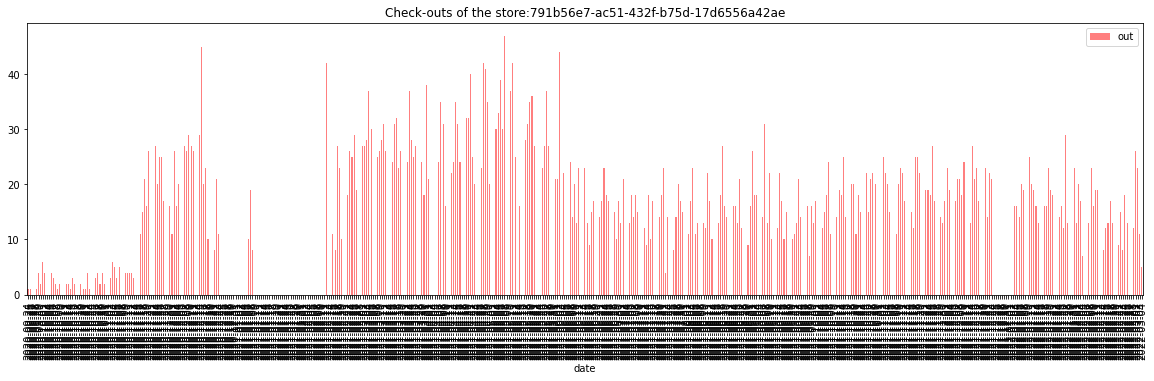

In [98]:


# plot
plt.figure(figsize=(20, 5))
plt.title(('Check-outs of the store:'+ selected_store))
(ops_day['out']*(-1)).plot.bar(color='Red', legend=True,  alpha=0.5)
#ops_day['in'].plot.bar(color='green', legend=True, alpha=0.5)

plt.yticks()
plt.show()

In [99]:
ops_day.tail()



out    in   sum       date
date                                   
2022-02-28 -12.0  17.0   5.0 2022-02-28
2022-03-01 -26.0  24.0  -2.0 2022-03-01
2022-03-02 -23.0  18.0  -5.0 2022-03-02
2022-03-03 -11.0  20.0   9.0 2022-03-03
2022-03-04  -5.0  17.0  12.0 2022-03-04

In [100]:
# Corr between check-ins and check-outs
ops_day[['out','in']].corr()

out        in
out  1.000000 -0.959078
in  -0.959078  1.000000

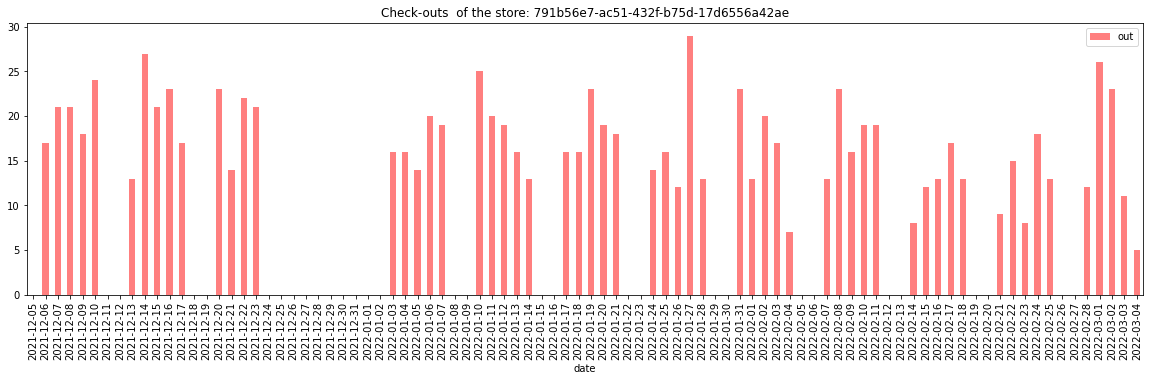

In [101]:
# plot last 120. days
plt.figure(figsize=(20, 5))
plt.title(('Check-outs  of the store: '+ selected_store))
(ops_day.tail(90)['out']*(-1)).plot.bar(color='Red', legend=True,  alpha=0.5)
#ops_day.tail(90)['in'].plot.bar(color='green', legend=True, alpha=0.5)

plt.yticks()
plt.show()

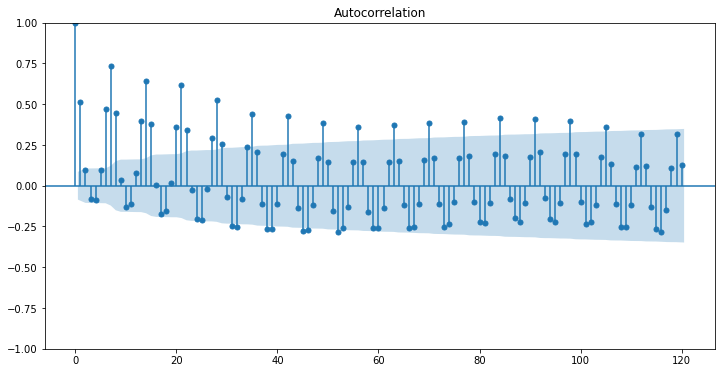

In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
#plt.title('Autocorrelation')
plot_acf(ops_day['out'], lags=120, ax=ax)
plt.show()

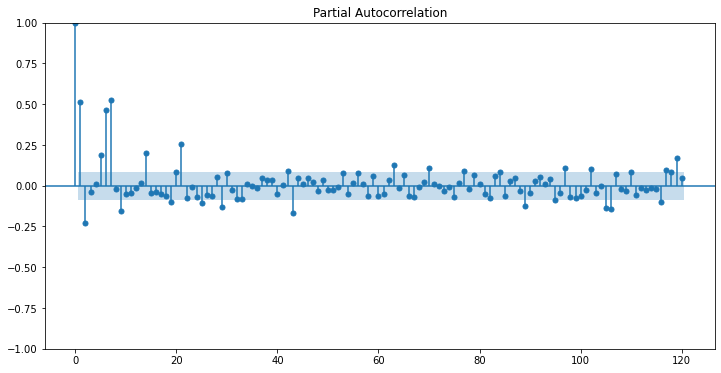

In [103]:
N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
#plt.title('Autocorrelation')
plot_pacf(ops_day['out'], lags=120, ax=ax, method='yw')
plt.show()

### Calendar Weekly

In [104]:
# create a new df after grouping by week.
ops_week=ops_day.drop('sum', axis=1).groupby([ops_day['date'].dt.year,ops_day['date'].dt.isocalendar().week]).min('out')
ops_week.reset_index()

ops_week['year_week']=list(zip(ops_week.reset_index()['date'].values,ops_week.reset_index()['week'].values))
ops_week.index=ops_week['year_week']
ops_week.tail(3)


out    in   year_week
year_week                         
(2022, 8)  -18.0   0.0   (2022, 8)
(2022, 9)  -26.0  17.0   (2022, 9)
(2022, 52)   0.0   0.0  (2022, 52)

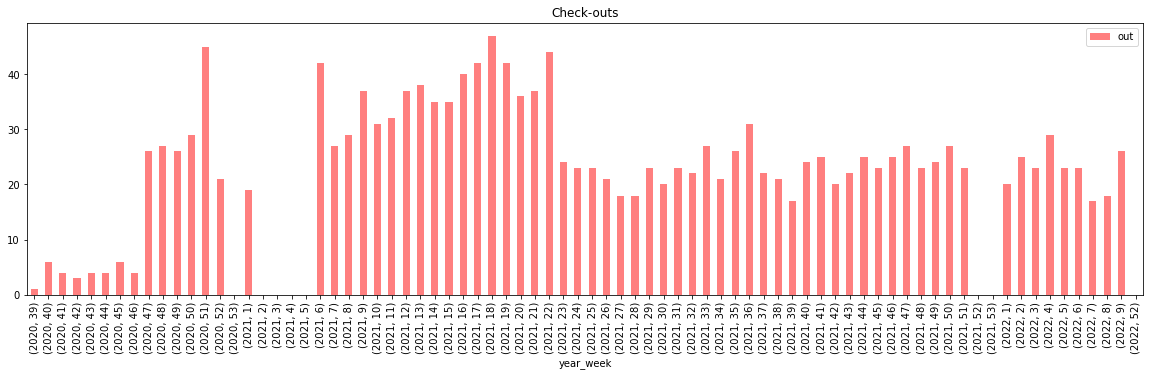

In [105]:
# plot

plt.figure(figsize=(20, 5))
plt.title('Check-outs')
(ops_week['out']*(-1)).plot.bar(color='Red', legend=True,  alpha=0.5)
#ops_week['in'].plot.bar(color='green', legend=True, alpha=0.5)

plt.show()

### Montly

In [106]:
ops_month=ops_day.drop('sum', axis=1).groupby([ops_day['date'].dt.year,ops_day['date'].dt.month]).min('out')
ops_month.index=ops_month.index.set_names(['year','month'])




ops_month=ops_day.drop('sum', axis=1).groupby([ops_day['date'].dt.year,ops_day['date'].dt.month]).min('out')
#ops_month.reset_index()

ops_month['year_month']=ops_month.index

ops_month.tail()


out    in  year_month
date date                        
2021 11   -27.0   0.0  (2021, 11)
     12   -27.0   0.0  (2021, 12)
2022 1    -29.0   0.0   (2022, 1)
     2    -23.0   0.0   (2022, 2)
     3    -26.0  17.0   (2022, 3)

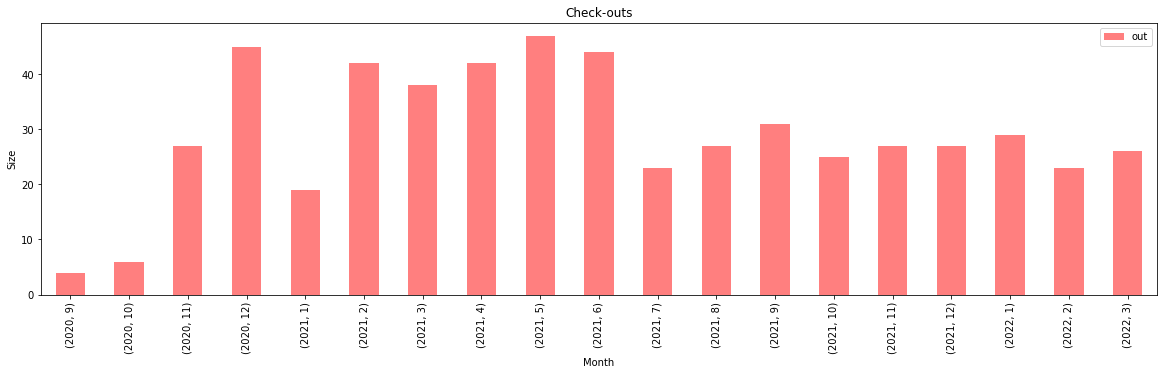

In [107]:
plt.figure(figsize=(20, 5))
plt.title('Check-outs')
(ops_month['out']*(-1)).plot.bar(color='Red', legend=True,  alpha=0.5)
#ops_month['in'].plot.bar(color='green', legend=True, alpha=0.5)
plt.xlabel('Month')
plt.ylabel('Size')
plt.show()

### Intraday

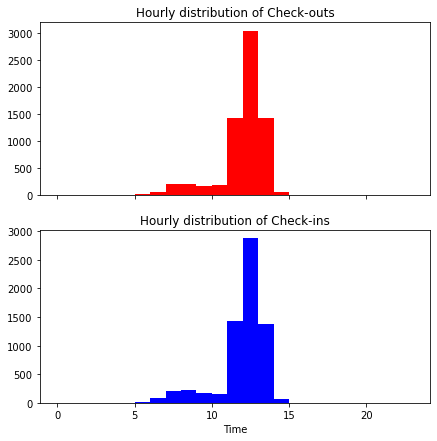

In [108]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(7,7))

ax1.hist(store_out['OwnerSince'].dt.hour,color='red' ,label='Check-outs', bins=list(range(24)))
ax1.set_title('Hourly distribution of Check-outs')


ax2.hist(store_in['OwnerTill'].dt.hour, color='blue',label='Check-ins', bins=list(range(24)))
ax2.set_title("Hourly distribution of Check-ins")
ax2.set_xlabel('Time')

plt.show()

In [109]:
ops_day[['in','out']].corr()

in       out
in   1.000000 -0.959078
out -0.959078  1.000000

## Prophet

In [110]:
import fbprophet
from fbprophet import Prophet

import json
from fbprophet.serialize import model_to_json, model_from_json
from datetime import timedelta
import plotly.offline as py
py.init_notebook_mode()

from sklearn.metrics import mean_absolute_error
from fbprophet.plot import (
    plot_plotly,
    plot_components_plotly,
    plot_forecast_component_plotly,
    plot_seasonality_plotly, 
    add_changepoints_to_plot
)

### Data preperation

In [111]:
# School holidays
ostern_2022 = pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2022-04-11', end='2022-04-23')}) 
ostern_2021 = pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2021-03-29', end='2021-04-10')})                            
ostern_2020 = pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2020-04-06', end='2020-04-18')})

pfingstferien_2021 = pd.DataFrame({'holiday': 'school_holiday','ds': pd.to_datetime(['2021-05-25'])})
pfingstferien_2020 = pd.DataFrame({'holiday': 'school_holiday','ds': pd.to_datetime(['2021-06-02'])})
                                   
sommerferien_2022= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2022-06-27', end='2022-08-09')})                          
sommerferien_2021= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2021-07-05', end='2021-08-17')})   
sommerferien_2020= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2020-06-29', end='2020-08-11')})  
 
herbstferien_2022= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2022-10-10', end='2022-10-15')}) 
herbstferien_2021= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2021-10-11', end='2021-10-23')}) 
herbstferien_2020= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2020-10-12', end='2020-10-24')})  
herbstferien_2019= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2019-10-14', end='2019-10-26')})  


weihnachtsferien_2022= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2022-12-23', end='2023-01-06')})                                
weihnachtsferien_2021= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2021-12-24', end='2022-01-08')})
weihnachtsferien_2020= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2020-12-21', end='2021-01-06')})
weihnachtsferien_2019= pd.DataFrame({'holiday': 'school_holiday','ds': pd.date_range(start='2019-12-23', end='2020-01-06')})


school_holidays = pd.concat([ostern_2022,ostern_2021,ostern_2020,\
                             pfingstferien_2021, pfingstferien_2020,\
                            sommerferien_2022,sommerferien_2021,sommerferien_2020,\
                             herbstferien_2022, herbstferien_2021,herbstferien_2020,herbstferien_2019,\
                            weihnachtsferien_2022,weihnachtsferien_2021,weihnachtsferien_2020,weihnachtsferien_2019,\
                             ])
school_holidays.tail()

holiday         ds
10  school_holiday 2020-01-02
11  school_holiday 2020-01-03
12  school_holiday 2020-01-04
13  school_holiday 2020-01-05
14  school_holiday 2020-01-06

In [112]:
weihnachten_business_2021=pd.DataFrame({'holiday': 'christmas_break','ds':pd.date_range(start='2021/12/23', periods=10)})
weihnachten_business_2020=pd.DataFrame({'holiday': 'christmas_break','ds':pd.date_range(start='2020/12/23', periods=10)})
weihnachten_business_2019=pd.DataFrame({'holiday': 'christmas_break', 'ds':pd.date_range(start='2019/12/23', periods=10)})

christmas = pd.concat([weihnachten_business_2021,weihnachten_business_2020,weihnachten_business_2019 ])
#christmas=christmas[christmas['ds'].dt.weekday.isin([0,1,2,3,4])]


In [113]:
import holidays
nrw_holidays = holidays.country_holidays('DE', subdiv='NW')
nrw_holidays

holidays.country_holidays('DE', subdiv='NW')

In [114]:
ops_day['ds']=ops_day.index

# Since holidays are similar to weekends, we merge them as 'holidays' 
for i, row in ops_day.iterrows():
    
    if int(row['ds'].weekday()) in [5,6] or row['ds'] in nrw_holidays:
        ops_day.loc[i, 'is_holiday']=True
    else: 
        ops_day.loc[i, 'is_holiday']=False

idx_=list(ops_day[ops_day['date'].isin(christmas['ds'])].index)
#ops_day.loc[idx_,'is_holiday']=True

In [115]:
ops_business=ops_day.copy(deep=True) #Save df for KDE analysis
%store ops_business
ops_day.loc[ops_day['ds'].isin(christmas['ds'].dt.date.values),'out']=None # remove christmas time

Stored 'ops_business' (DataFrame)


In [116]:
# convert check-outs to positive numbers
# create columns for prophet
ops_day['out']=ops_day['out']**2
ops_day['out']=ops_day['out']**(1/2)
ops_day['y']=ops_day['out']

ops_day['ds']=ops_day.index

In [117]:
#ops_day.tail(80).head(13)

In [118]:
#begin_date=dt.datetime(2019, 8, 1, 0, 0, 0, tzinfo=dt.timezone.utc)
break_date=dt.datetime(2022, 2, 21).date()


# create test dataset, remove last.. days
train = ops_day[ops_day.index<break_date]
future=ops_day[ops_day.index>=break_date]
#train.tail()

In [119]:
# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [120]:
# to surpress the print outs
with suppress_stdout_stderr():
    
    model = Prophet(growth='linear',# default
                    changepoint_range=.8,# default
                    seasonality_mode='additive',\
                    #holidays=christmas,holidays_prior_scale=10,
                    yearly_seasonality=False,
                    daily_seasonality=False, \
                    weekly_seasonality=False)
    model.add_seasonality(name='weekly', period=7, fourier_order=10, prior_scale=10, mode='multiplicative')
    model.add_regressor(name='is_holiday', prior_scale=10, standardize='auto', mode='multiplicative')
    model.fit(train)

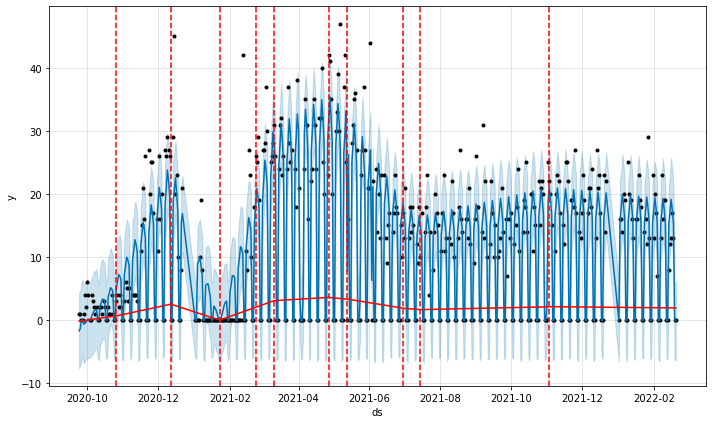

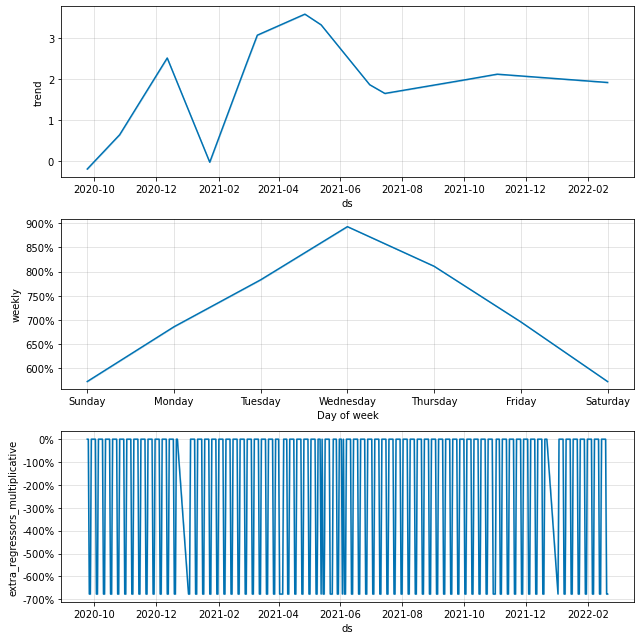

In [121]:
# use the model to make a forecast
forecast = model.predict()
fig=model.plot(forecast)
add_changepoints_to_plot(fig.gca(),model, forecast)
plt.show()
fig2=model.plot_components(forecast)
plt.show()

In [122]:
from fbprophet.utilities import regressor_coefficients
regressor_coefficients(model)

regressor  regressor_mode  center  coef_lower      coef  coef_upper
0  is_holiday  multiplicative     0.0   -6.772116 -6.772116   -6.772116

In [123]:
#forecast.tail(5).T

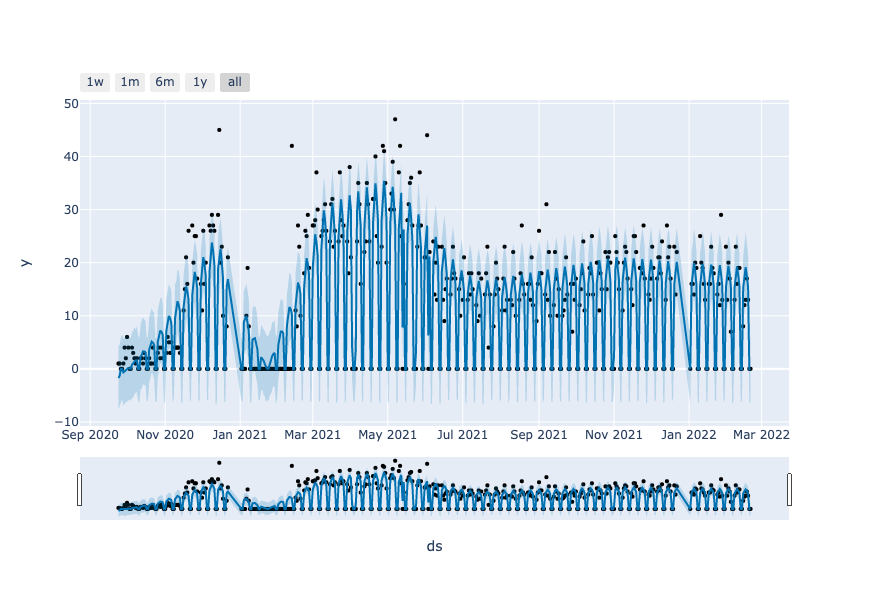

In [124]:
fig = plot_plotly(model, forecast, trend=False)

py.iplot(fig)

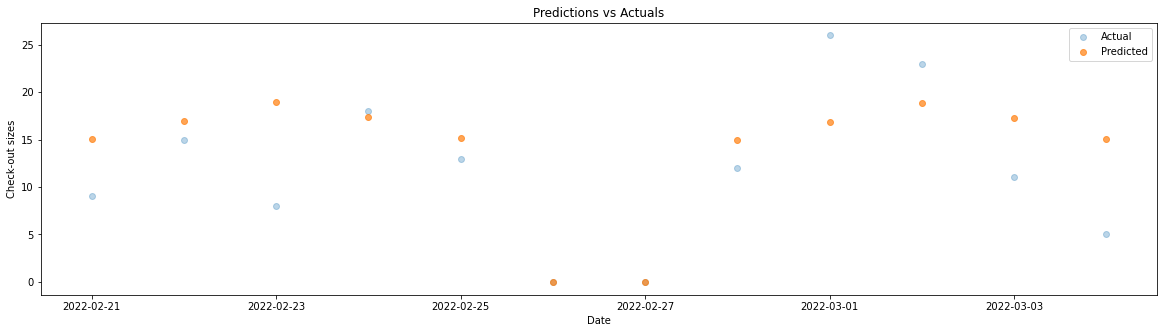

In [125]:
# use the model to make a forecast
forecast = model.predict(future)
# calculate MAE between expected and predicted values for december
y_true = future['y']
y_pred = forecast['yhat']

# plot expected vs actual
plt.figure(figsize=(20, 5))
plt.scatter(future.index,future['y'], alpha=0.3, label='Actual')
plt.scatter(forecast.ds,forecast['yhat'], alpha=0.7,label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.title('Predictions vs Actuals')
plt.ylabel('Check-out sizes')
plt.show()

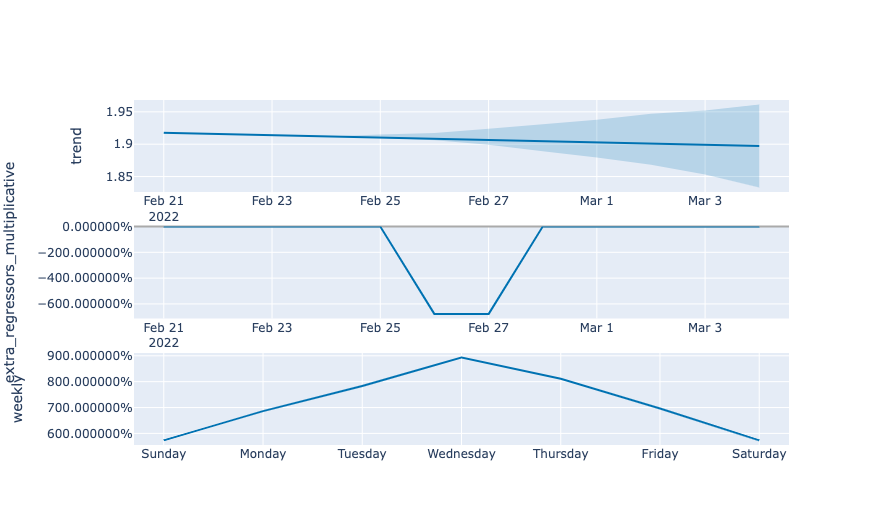

In [126]:
fig = plot_components_plotly(model, forecast , figsize=(800, 175))
py.iplot(fig)

### Rolling validation

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [128]:
# See Rafferty,Forecasting_Time-Series-Data-with-Facebook-Prophet, Chapter 11 for the arguments below.
with suppress_stdout_stderr():
    df_cv = cross_validation(model,
                         horizon='1 days', # length of time to be forecasted
                         period='1 days', # period of time to start the forecasting process 
                         initial='500 days', # intitial train set
                         parallel='processes') #about computation

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-06 00:00:00 and 2022-02-19 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe165060700>


In [129]:
df_cv

ds       yhat  yhat_lower  yhat_upper     y     cutoff
0  2022-02-07  16.748925   10.503126   23.035957  13.0 2022-02-06
1  2022-02-08  18.383981   11.945367   24.338566  23.0 2022-02-07
2  2022-02-09  21.016769   14.931279   26.894820  16.0 2022-02-08
3  2022-02-10  18.833269   13.025687   24.660461  19.0 2022-02-09
4  2022-02-11  16.377468   10.440200   22.524849  19.0 2022-02-10
5  2022-02-12  -0.083953   -6.439928    5.813153   0.0 2022-02-11
6  2022-02-13  -0.125351   -6.192430    5.856707   0.0 2022-02-12
7  2022-02-14  16.185953   10.139161   22.290768   8.0 2022-02-13
8  2022-02-15  18.011922   11.699567   23.884472  12.0 2022-02-14
9  2022-02-16  19.803314   13.665351   25.469382  13.0 2022-02-15
10 2022-02-17  17.711578   11.678867   24.194783  17.0 2022-02-16
11 2022-02-18  15.551490    9.469519   21.787626  13.0 2022-02-17
12 2022-02-19  -0.088492   -6.574375    5.374325   0.0 2022-02-18
13 2022-02-20  -0.109383   -6.089613    6.455915   0.0 2022-02-19

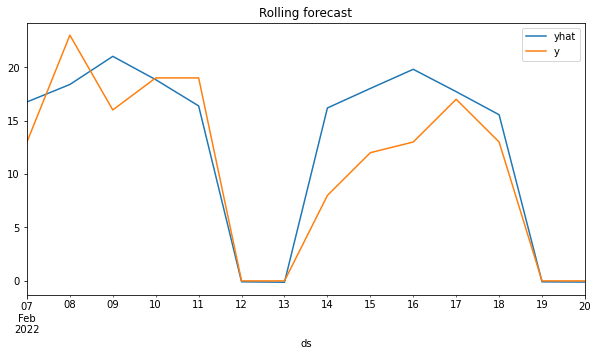

In [130]:
df_cv.set_index('ds')[['yhat','y']].plot(figsize=(10,5))
plt.title('Rolling forecast')
plt.show()

### Removing outliers

#### Eliminate 1.65 sd above the mean

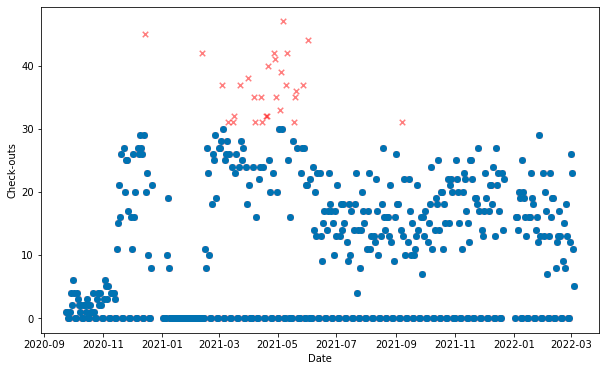

In [131]:
from scipy import stats
df=ops_day
df5 = ops_day.copy().dropna()
df5 = df5[(stats.zscore(df5['y']) < 1.65)] #eliminate 1.65 sd above the mean

plt.figure(figsize=(10, 6))
plt.scatter(x=ops_day['ds'], y=ops_day['y'], c='r', alpha=.5, marker='x', s=30)
plt.scatter(x=df5['ds'], y=df5['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Check-outs')
plt.show()

#### Moving Average
Noise analysis

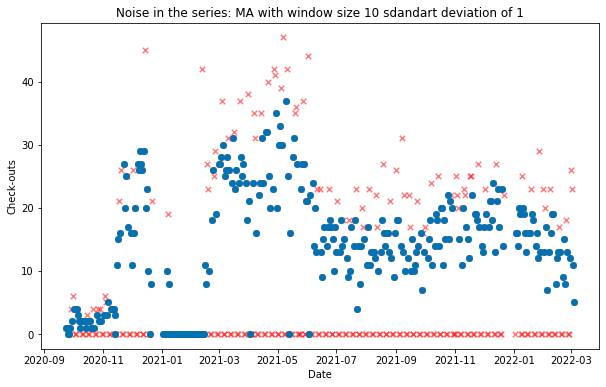

In [132]:
df6 = df.copy().dropna()
roll=10
sd_=1
df6['moving_average'] = df6.rolling(window=roll,
                                    min_periods=1,
                                    center=True,
                                    on='ds')['y'].mean()
df6['std_dev'] = df6.rolling(window=roll,
                             min_periods=1,
                             center=True,
                             on='ds')['y'].std()
df6['lower'] = df6['moving_average'] - sd_ * df6['std_dev']
df6['upper'] = df6['moving_average'] + sd_ * df6['std_dev']

df6 = df6[(df6['y'] < df6['upper']) & (df6['y'] > df6['lower'])]

plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='r', alpha=.5, marker='x', s=30)
plt.scatter(x=df6['ds'], y=df6['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
text='Noise in the series: MA with window size '+ str(roll)+ ' sdandart deviation of '+ str(sd_)
plt.title(text )
plt.xlabel('Date')
plt.ylabel('Check-outs')
plt.show()

We can improve the forecasting model if we know the reasons behind those extreme observations.<br>
Zeros are possibly related to the opening days of the store.  <br> Thus, we can model those days as a regressor. 


### Scikit-learn KDE
https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py

https://scikit-learn.org/stable/modules/density.html

In [133]:
min(ops_day.index), max(ops_day.index)

(datetime.date(2020, 9, 24), datetime.date(2022, 3, 4))

In [134]:
#remove holidays and closed days
#ops_business=ops_day[(ops_day['is_open']==1)] # not reliable


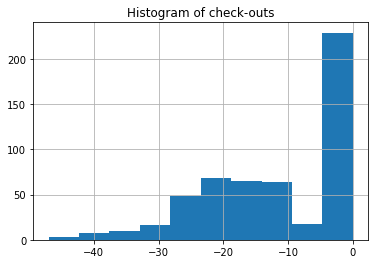

In [135]:

ops_business['out'].hist()
plt.title('Histogram of check-outs')
plt.show()

In [136]:
import numpy as np
from sklearn.neighbors import KernelDensity

from sklearn.model_selection import GridSearchCV

# We work on the series of 2021
# define a day to divide the data set in two parts ; train, test
start_date=pd.to_datetime('20210101', format='%Y%m%d', errors='coerce')
break_date=pd.to_datetime('20220101', format='%Y%m%d', errors='coerce')

# create test dataset, break it at a date
# 2021 is train set, 2022 is test set
x_train = ops_business[(ops_business.index<break_date) & (ops_business.index>start_date)]['out'].values.reshape(-1,1)
x_test = ops_business[ops_business.index>=break_date]['out'].values.reshape(-1,1)





In [137]:
rng=list(range(int(min(x_train)), int(max(x_train))))
rng=np.array(list(rng)).reshape(-1,1)

In [138]:
model = KernelDensity()# default = guassian
model.fit(x_train)
log_dens = model.score_samples(x_test)
probs = np.exp(log_dens)

df=pd.DataFrame(x_test, probs, columns=['observation']).reset_index().\
rename(columns={'index':'prob'}).set_index('observation').drop_duplicates().sort_values('observation').reset_index()
df.tail()

observation      prob
14         -9.0  0.011865
15         -8.0  0.007221
16         -7.0  0.003647
17         -5.0  0.000851
18          0.0  0.155632

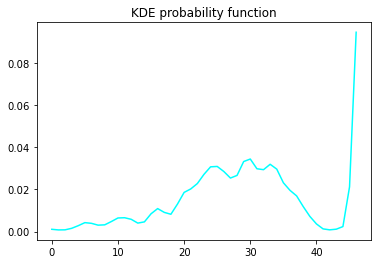

In [139]:
plt.plot(np.exp(model.score_samples(rng)), color='cyan')
plt.title('KDE probability function')
plt.show()

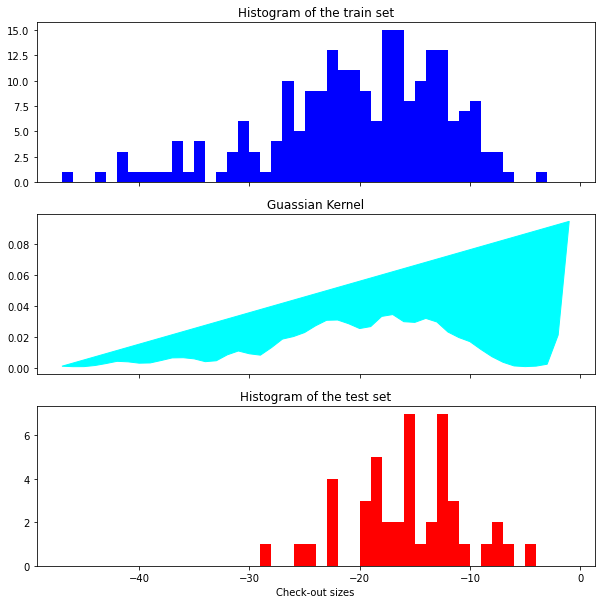

In [140]:
bins=list(range(int(min(x_train)), int(max(x_train))))
fig, [ax1, ax2,ax3] = plt.subplots(3, 1, sharex=True, figsize=(10,10))

ax1.hist(x_train,color='blue' ,label='train', bins=bins)
ax1.set_title('Histogram of the train set')
ax2.set_title("Guassian Kernel")
ax2.fill( bins,np.exp(model.score_samples(rng)), label='KDE function',c='cyan')

ax3.hist(x_test, color='red',label='test', bins=bins)
ax3.set_title('Histogram of the test set')
ax3.set_xlabel('Check-out sizes')
plt.show()

In [141]:
print(np.trapz(probs.ravel(), x_test.ravel())) # https://numpy.org/doc/stable/reference/generated/numpy.trapz.html

-1.3269840898981553


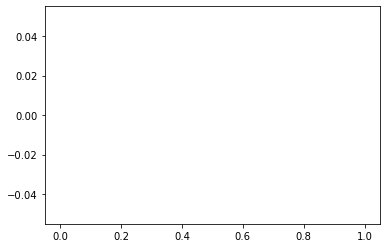

In [142]:
ops_business=ops_business[ops_business['out']>0] # remove the days that store has zero check-outs

# create test dataset, break it at a date
x_train = ops_business[(ops_business.index<break_date) & (ops_business.index>start_date)]['out'].values.reshape(-1,1)
x_test = ops_business[ops_business.index>=break_date]['out'].values.reshape(-1,1)
plt.hist(x_train)
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KernelDensity.

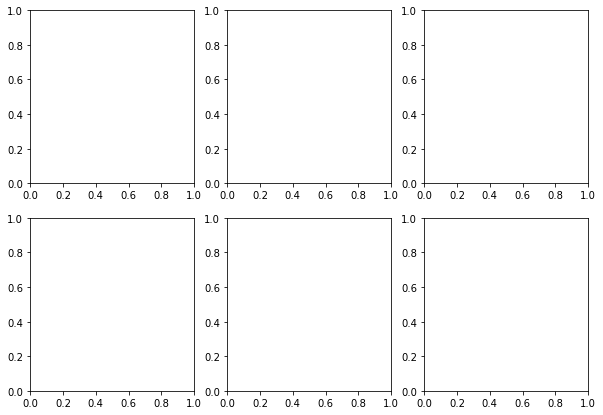

In [143]:
bandwidths = [0.01, 0.05, 0.1, 0.5, 1, 4]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
plt_ind = np.arange(6) + 231

for b, ind in zip(bandwidths, plt_ind):
    kde_model = KernelDensity(kernel='gaussian', bandwidth=b)
    kde_model.fit(x_train)
    score = kde_model.score_samples(x_test)
    probs = np.exp(score)
    plt.subplot(ind)
    df=pd.DataFrame(x_test, probs, columns=['observation']).reset_index().\
    rename(columns={'index':'prob'}).set_index('observation').drop_duplicates().sort_values('observation').reset_index()
    df
    plt.plot(df['observation'], df['prob'], c='cyan')
    plt.title("h="+str(b))

fig.subplots_adjust(hspace=0.5, wspace=.3)
plt.show()

In [ ]:

bandwidth = np.arange(0.05, 4, .05)
kde = KernelDensity(kernel='gaussian')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(x_train)

kde = grid.best_estimator_
log_dens = kde.score_samples(x_test)
df=pd.DataFrame(x_test, np.exp(log_dens), columns=['observation']).reset_index().\
rename(columns={'index':'prob'}).set_index('observation').drop_duplicates().sort_values('observation').reset_index()

bins=list(range(int(min(x_train)), int(max(x_train))))
fig, [ax1, ax2,ax3] = plt.subplots(3, 1, sharex=True, figsize=(10,10))

ax1.hist(x_train,color='blue' ,label='train', bins=bins)
ax1.set_title('Histogram of the train set')
ax2.set_title("Guassian Kernel with band width "+ "{:.2f}".format(kde.bandwidth))
ax2.fill(bins,np.exp(model.score_samples(rng)), label='KDE function',c='cyan')

ax3.hist(x_test, color='red',label='test', bins=bins)
ax3.set_title('Histogram of the test set')
ax3.set_xlabel('Check-out sizes')
plt.show()



### Grid Search with Multiple Kernel Functions

In [ ]:
# customized scoring function for Grid Search
def my_scores(estimator,X):
    scores = estimator.score_samples(x_test)
    # Remove -inf
    scores = scores[scores != float('-inf')]
    # Return the mean values
    return np.mean(scores)


In [ ]:
# Available kernels in Scikit-learn
kernels = ['cosine', 'epanechnikov', 'exponential', 'gaussian', 'linear', 'tophat']
h_vals = np.arange(0.1, 10, .1)

In [ ]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': h_vals, 'kernel': kernels},
                   scoring=my_scores)
grid.fit(x_train)
best_kde = grid.best_estimator_
log_dens = best_kde.score_samples(x_test)

df=pd.DataFrame(x_test, np.exp(log_dens), columns=['observation']).reset_index().\
rename(columns={'index':'prob'}).set_index('observation').drop_duplicates().sort_values('observation').reset_index()




fig, [ax1, ax2,ax3] = plt.subplots(3, 1, sharex=True, figsize=(10,10))

ax1.hist(x_train,color='blue' ,label='train', bins=bins)
ax1.set_title('Histogram of the train set')
ax2.set_title("Best Kernel: " + best_kde.kernel+", band width="+"{:.2f}".format(best_kde.bandwidth))
ax2.fill(bins,np.exp(model.score_samples(rng)), label='KDE function',c='cyan')

ax3.hist(x_test, color='red',label='test', bins=bins)
ax3.set_title('Histogram of the test set')
ax3.set_xlabel('Check-out sizes')
plt.show()